In [47]:
from torch import nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import sys
import platform
from IPython.display import clear_output
from tqdm.notebook import tqdm
from time import sleep
import numpy as np

In [3]:
# What version of Python do you have?

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps:0" if getattr(torch,'has_mps',False) \
    else "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.4.1-arm64-arm-64bit
PyTorch Version: 2.1.0.dev20230416

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps:0


### Load MNIST

In [36]:
EPOCHS = 50
batch_size = 32


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)
])



trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

dataiter = iter(testloader)
images, labels = next(dataiter)
random_image = images[0]


# display(T.ToPILImage()(inverse_transform(random_image).squeeze(0)).resize((200, 200)))

undo_transform = T.Normalize(mean=-1.0, std=2.0)

In [56]:
class G_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, X):
        return self.model(X).view(-1, 28, 28)

class D_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 28 * 28),
            nn.LeakyReLU(0.2),
            nn.Linear(28 * 28, 1),
            nn.LeakyReLU(0.2),
        )


    def forward(self, X):
        X_ = X.view(batch_size, -1)
        return self.model(X_)

class GAN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        # terrible thing with device, mb this this
        self.G = G_model().to(device)
        self.D = D_model().to(device)

    def forward(self, n):
        noise = torch.randn((n, 100), device=self.device)
        return self.G(noise)

    def train_(self, dataloader, EPOCHS=100, verbose=True):
        num_imgs = 15
        noise_fixed = torch.randn((num_imgs, 100), device=self.device)

        criterion = nn.BCEWithLogitsLoss()

        optimizer_G = torch.optim.Adam(
            self.G.parameters(), lr=3e-4)
        optimizer_D = torch.optim.Adam(
            self.D.parameters(), lr=3e-4)


        batch_size = dataloader.batch_size
        G_loss_lst, D_loss_lst = [], []

        for epoch in tqdm(range(EPOCHS), desc="Epoch"):
            G_running_loss_lst = []
            D_running_loss_lst = []
            for i, (X, _) in enumerate(tqdm(dataloader, leave=False, desc=f"Epoch {epoch}")):
                # Label Smoothing,
                # i.e. if you have two target labels:
                # Real=1 and Fake=0, then for each incoming sample, if it is real,
                # then replace the label with a random number between 0.7 and 1.2,
                # and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
                # Salimans et. al. 2016
                ones = (0.7 - 1.2) * torch.rand(batch_size,
                                                device=self.device) + 1.2
                zeros = 0.3 * torch.rand(batch_size, device=self.device)


                # ones = torch.ones(batch_size, device=self.device)
                # zeros = torch.zeros(batch_size, device=self.device)

                noise = torch.randn((batch_size, 100), device=self.device)

                # iteration for discriminator
                z = self.G(noise)

                pred_fake = self.D(z.detach()).squeeze(-1)
                pred_real = self.D(X.to(self.device)).squeeze(-1)

                D_loss = criterion(pred_fake, zeros) + \
                    criterion(pred_real, ones)

                D_loss.backward()
                optimizer_D.step()
                D_running_loss_lst.append(D_loss.item())

                # iteration for the generator
                pred = self.D(z).squeeze(-1)
                G_loss = criterion(pred, ones)

                G_loss.backward()
                optimizer_G.step()
                G_running_loss_lst.append(G_loss.item())

                optimizer_D.zero_grad()
                optimizer_G.zero_grad()


                # fix noise + logging
                if (i + 1) % 500 == 0:
                    self.eval()
                    with torch.no_grad():
                        # Adjust the figsize as per your preference
                        _, axs = plt.subplots(1, num_imgs, figsize=(17, 6))

                        # imgs = self.G(noise_fixed)
                        imgs = self.G(noise_fixed)
                        for j, img in enumerate(imgs):
                            axs[j].imshow(
                                undo_transform(img.cpu().detach().view(1, 28, 28)).view(28, 28).numpy(), cmap="gray")

                        plt.show()
                        self.train()

                        print("G_loss:", np.mean(G_running_loss_lst), "D_loss:", np.mean(D_running_loss_lst))
                        plt.plot(torch.tensor(G_running_loss_lst).view(-1, 10).mean(1), label='G-loss')
                        plt.plot(torch.tensor(D_running_loss_lst).view(-1, 10).mean(1), label='D-loss')
                        plt.legend(loc='upper right')
                        plt.show()

            G_loss_lst.append(np.mean(G_running_loss_lst))
            D_loss_lst.append(np.mean(D_running_loss_lst))

            print("G_loss:", np.mean(G_running_loss_lst), "D_loss:", np.mean(D_running_loss_lst))
            plt.plot(G_running_loss_lst, label='G-loss')
            plt.plot(D_running_loss_lst, label='D-loss')
            plt.legend(loc='upper right')
            plt.show()

        return G_loss_lst, D_loss_lst


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/1875 [00:00<?, ?it/s]

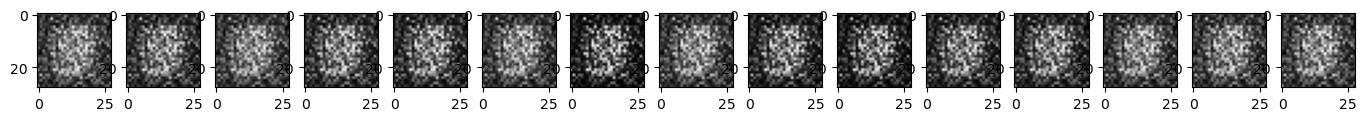

G_loss: 1.053208537220955 D_loss: 0.8584357506632805


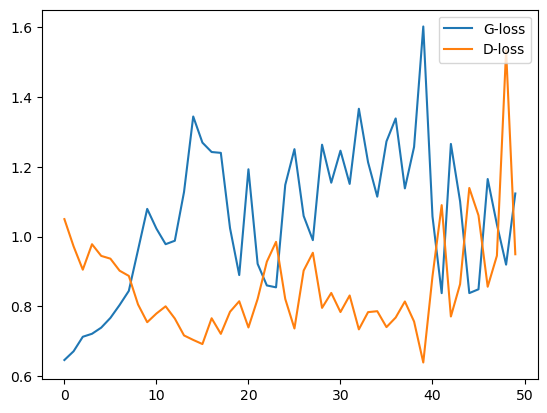

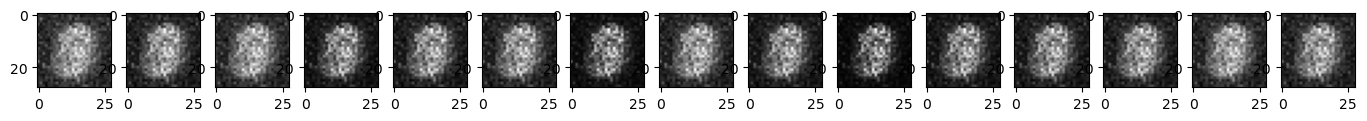

G_loss: 1.0464766486883164 D_loss: 0.9063185153305531


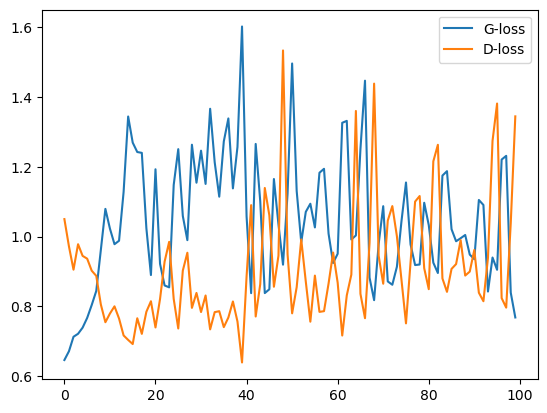

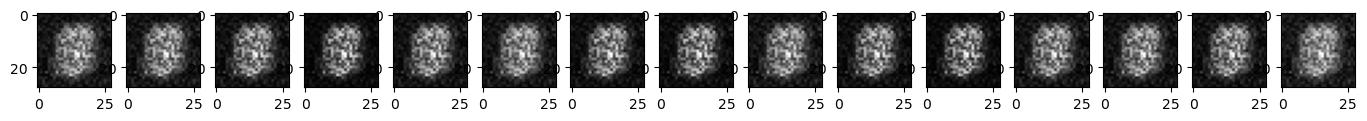

G_loss: 1.0068779808282853 D_loss: 0.9939049022197723


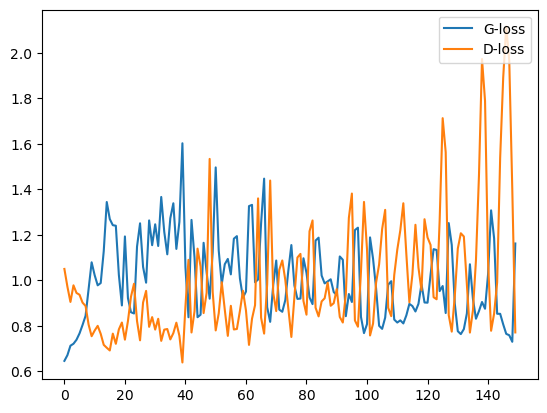

G_loss: 0.9843169757525126 D_loss: 1.0089058148701986


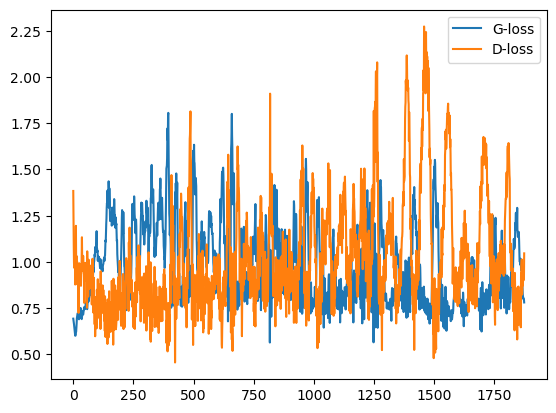

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

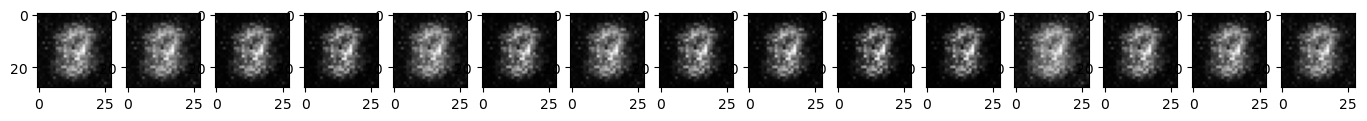

G_loss: 0.8929820864200592 D_loss: 0.9980952152013779


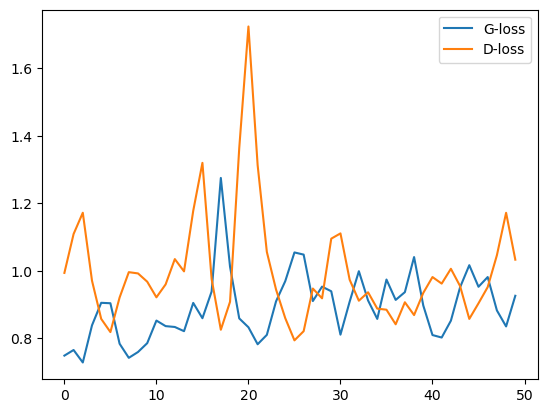

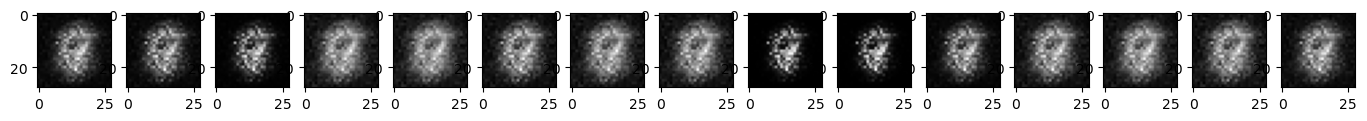

G_loss: 0.9606904518604279 D_loss: 0.9577691341042519


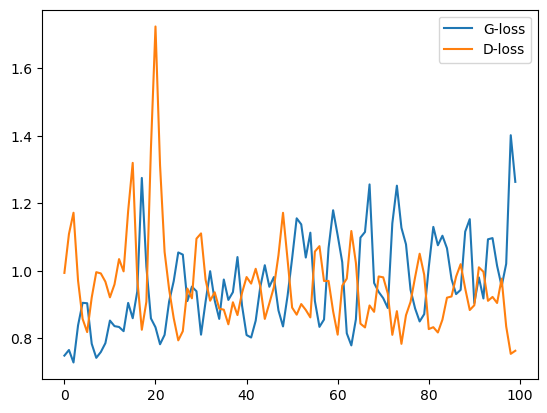

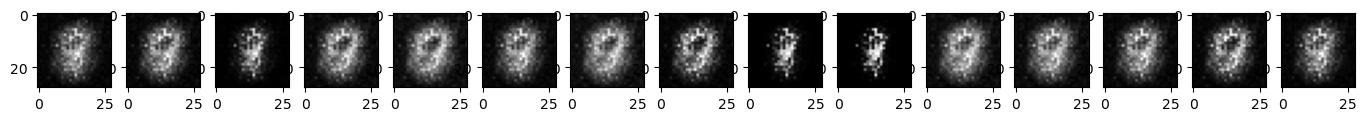

G_loss: 0.988147573073705 D_loss: 0.9599654515385627


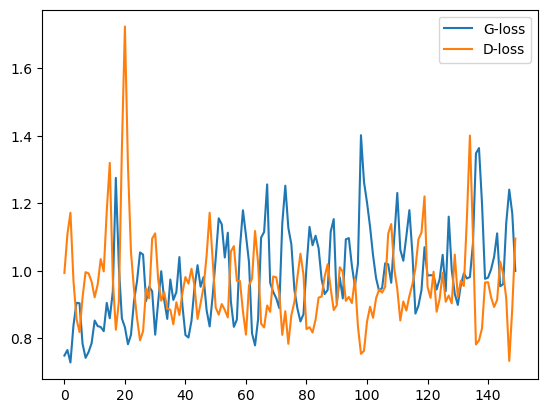

G_loss: 1.0025599866231283 D_loss: 0.9535015142917633


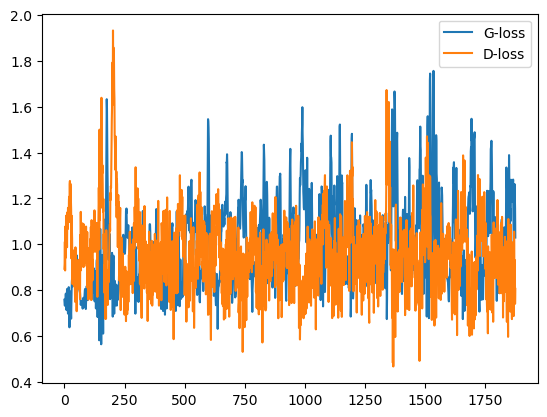

Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

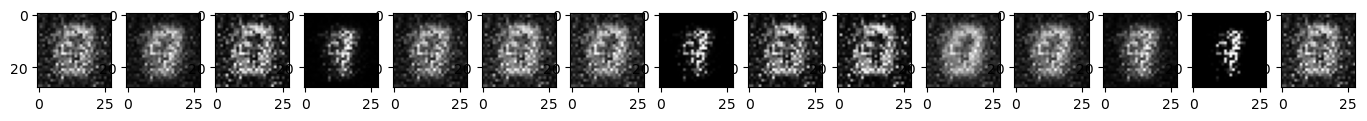

G_loss: 1.1247282774448395 D_loss: 0.8939335894584656


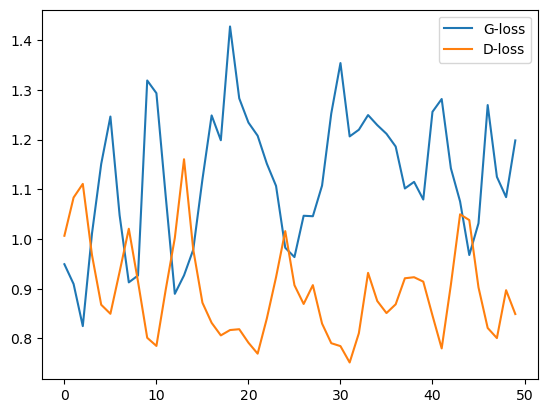

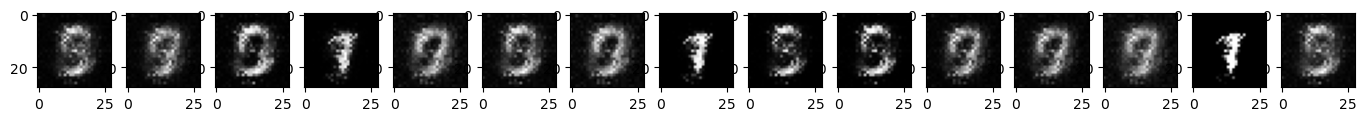

G_loss: 1.1535549234747886 D_loss: 0.8790733761787415


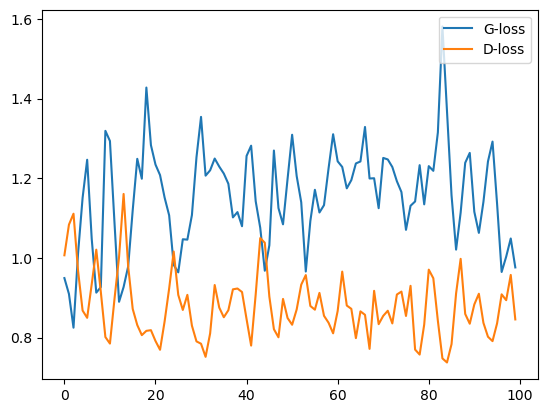

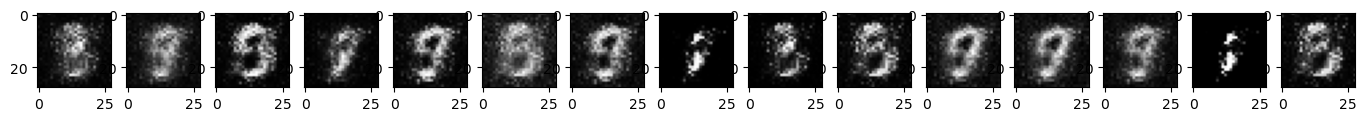

G_loss: 1.1691451237599055 D_loss: 0.8733691593209902


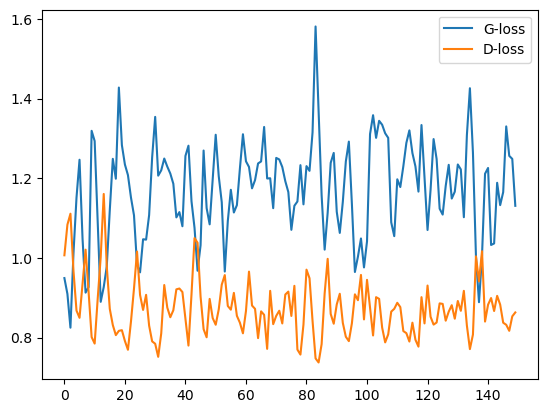

G_loss: 1.1737838605880737 D_loss: 0.8767607930024465


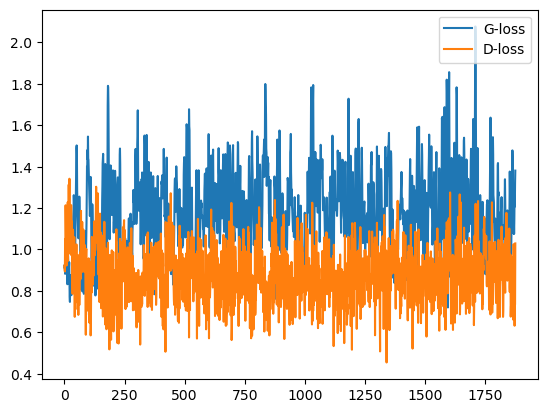

Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

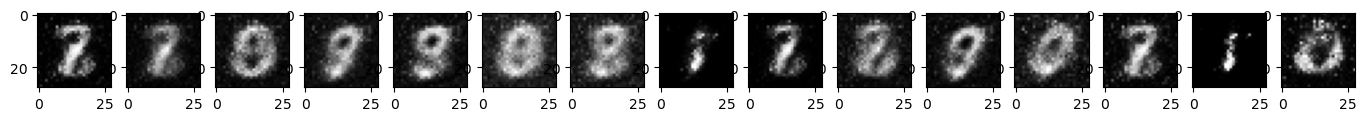

G_loss: 1.1135948349237441 D_loss: 0.8907946764230729


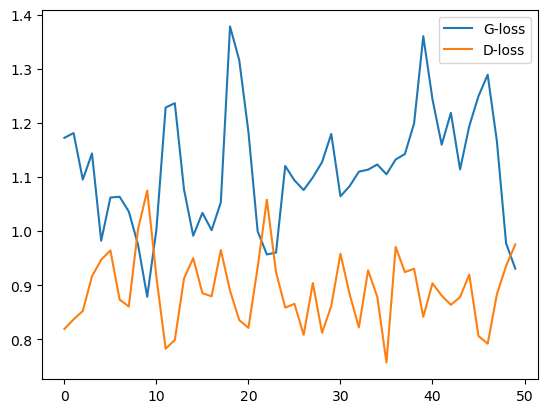

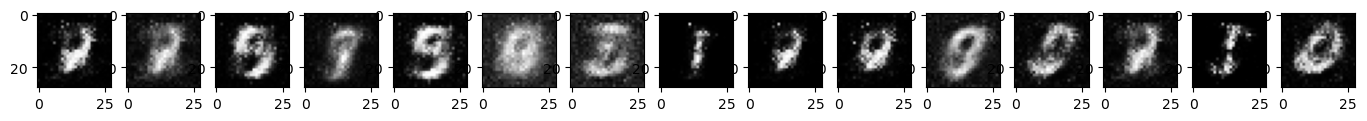

G_loss: 1.1020421780347824 D_loss: 0.9262995095849037


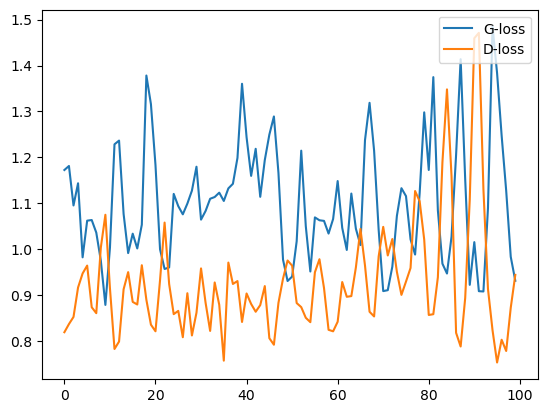

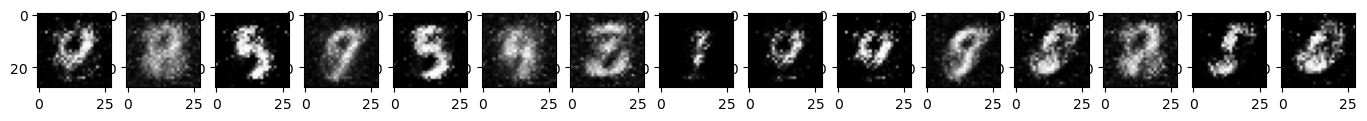

G_loss: 1.0832435113191605 D_loss: 0.9373031905094783


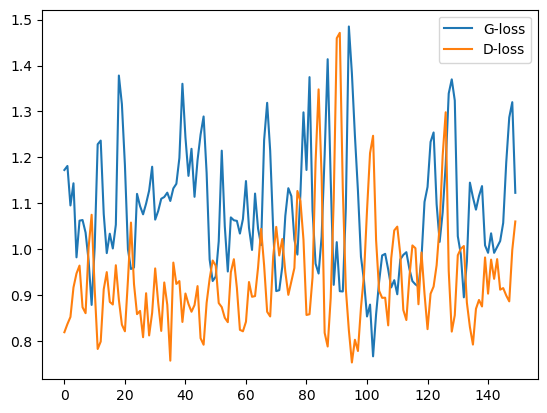

G_loss: 1.1022373810768127 D_loss: 0.9373458545684814


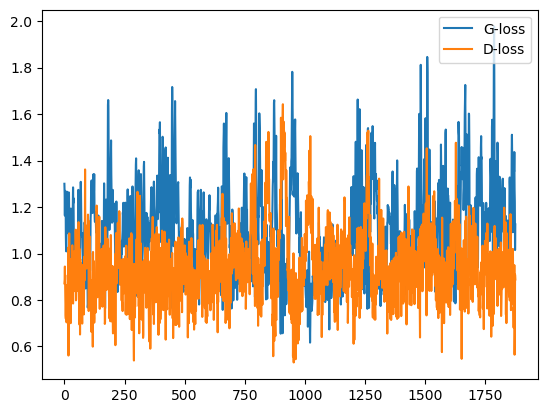

Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]

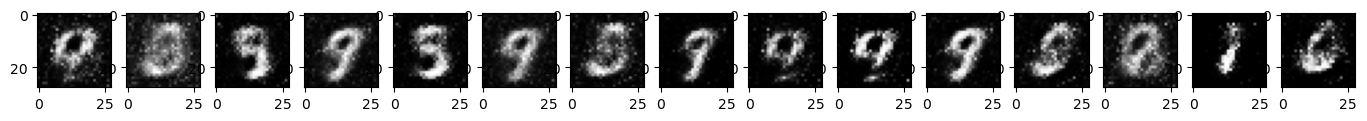

G_loss: 1.1137653082609176 D_loss: 0.963569822371006


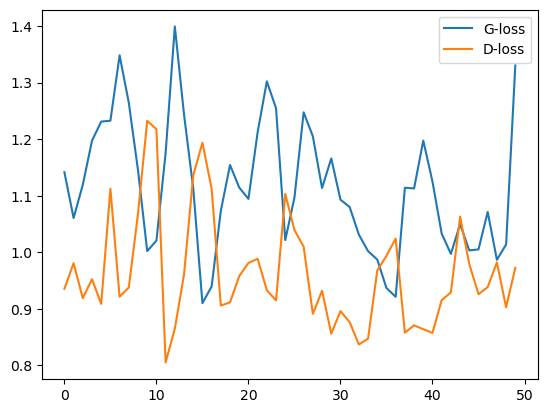

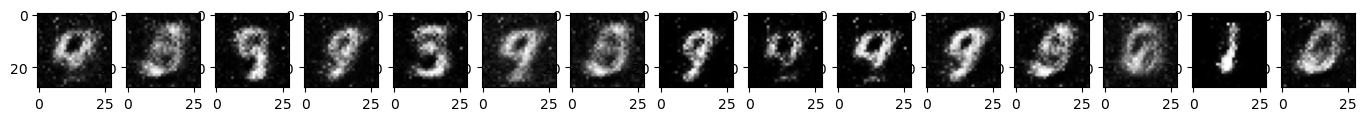

G_loss: 1.0933272911906242 D_loss: 0.9624702144563199


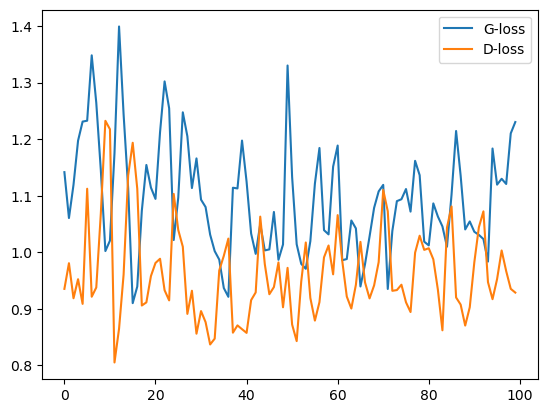

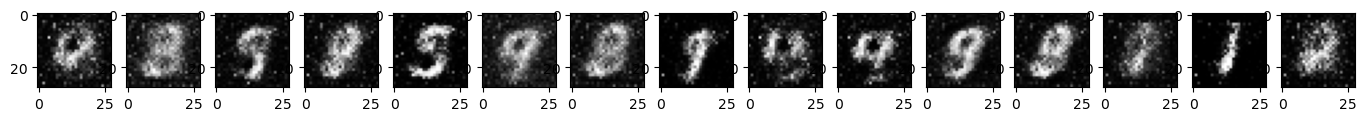

G_loss: 1.0931801452636718 D_loss: 0.9656373080611229


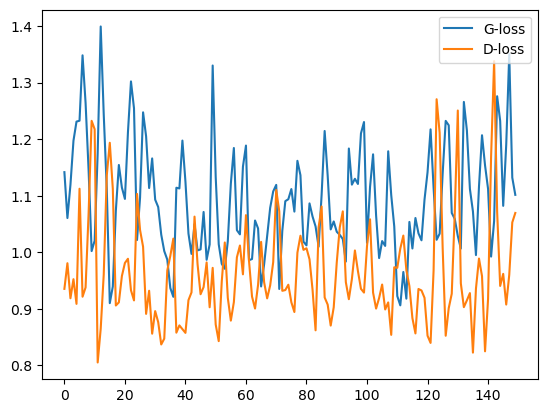

G_loss: 1.0936384319305419 D_loss: 0.9671543111165365


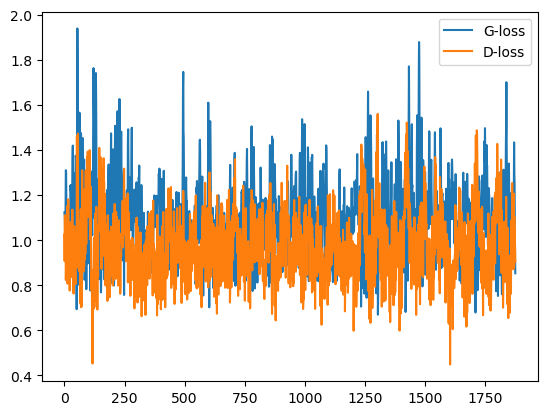

Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]

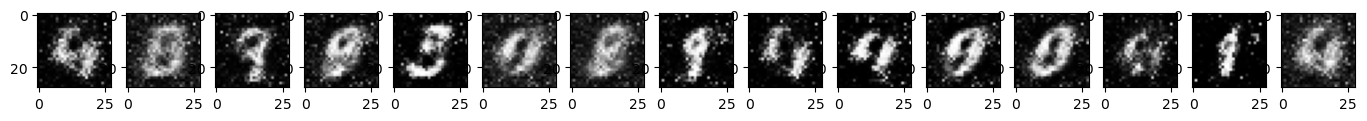

G_loss: 1.0569652268886567 D_loss: 0.9616197080612182


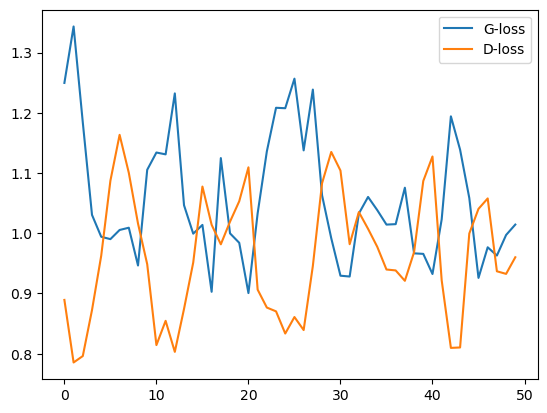

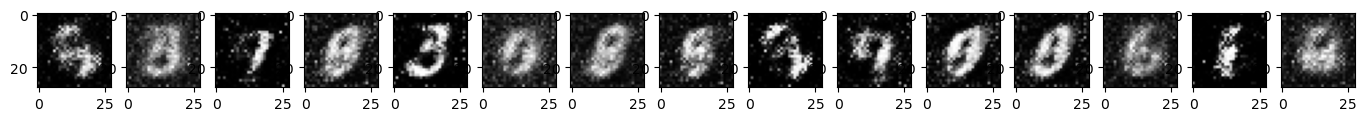

G_loss: 1.0782178992033005 D_loss: 0.954433389544487


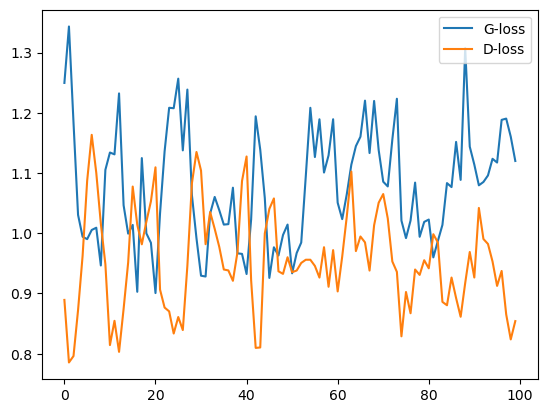

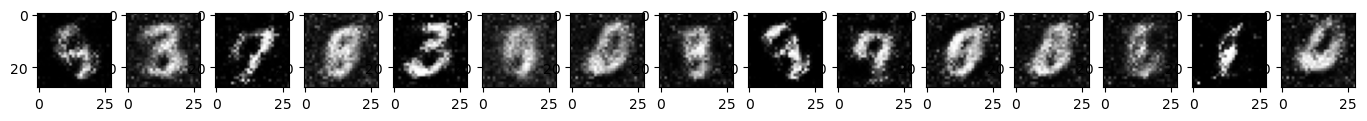

G_loss: 1.089958409190178 D_loss: 0.940389377951622


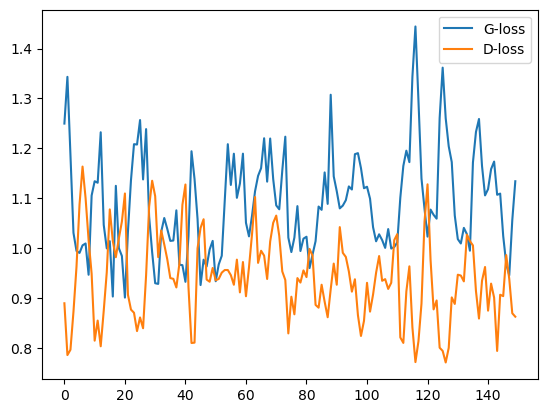

G_loss: 1.0900130809783934 D_loss: 0.9450166965166727


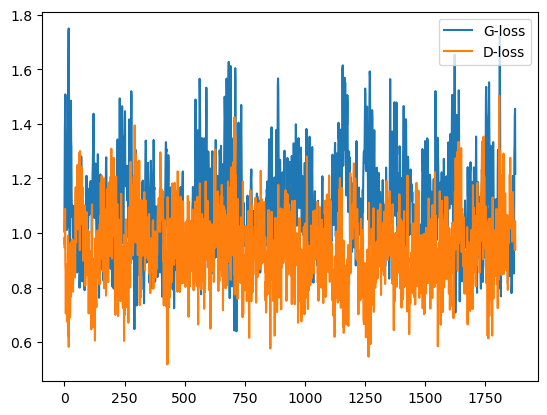

Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]

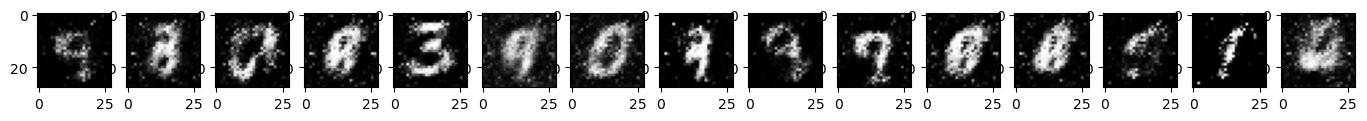

G_loss: 1.077389330148697 D_loss: 0.9687888112068176


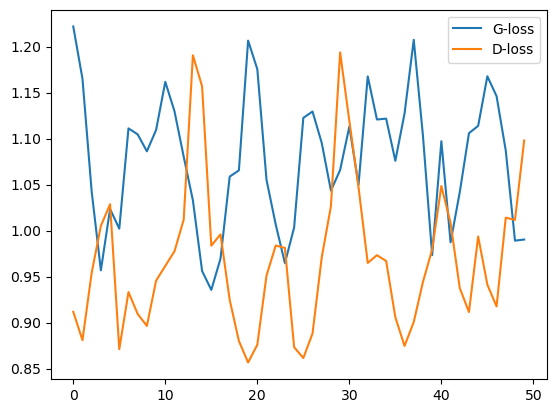

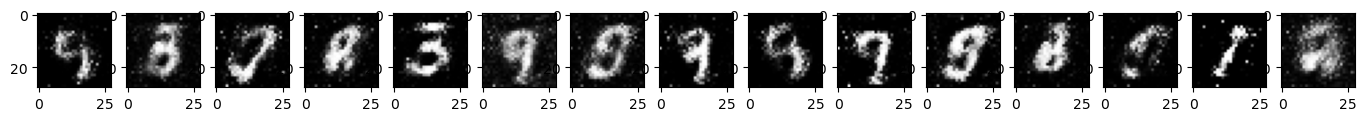

G_loss: 1.0666378193497659 D_loss: 0.9676306958198547


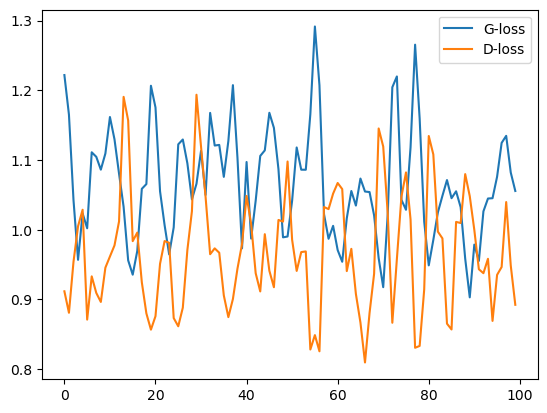

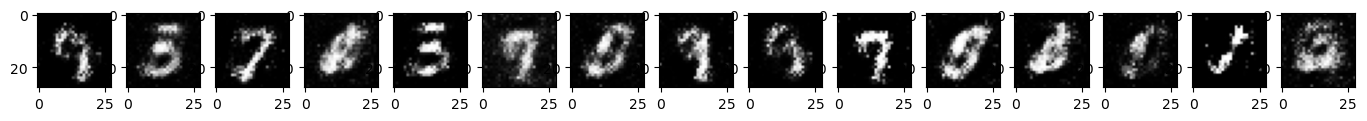

G_loss: 1.065891282359759 D_loss: 0.9709946889877319


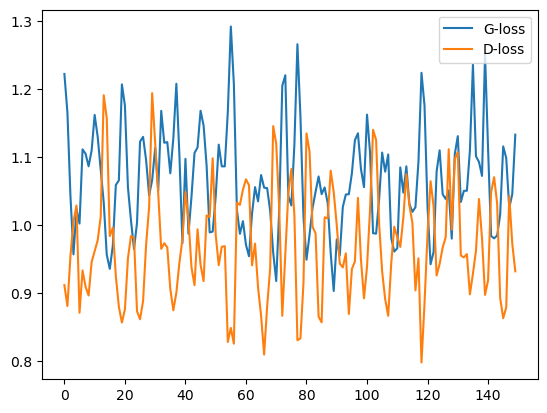

In [57]:
model = GAN(device)
model.train_(trainloader, EPOCHS)